# Setup

In [74]:
jsoc_email = "hudson.harner657@topper.wku.edu"

In [75]:
%matplotlib inline
import sunpy
import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import scipy

#Set default figure size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import datetime
#import ffmpeg
#import torch
from ast import literal_eval as make_tuple

In [76]:
#Pick an already downloaded datacube to analyze

#Copy the file name here:
filename = 'datacube_2017-04-01T211500_200_200_7_50.fits'

#Find the start date of the flare and write it in, add one day for the end day
startday = '2017-04-01'
endday = '2017-04-02'
results = Fido.search(a.Time(startday, endday), a.hek.FL, a.hek.FL.GOESCls > "M1.0")
results.show()

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str131,str1,str115,str5,str20,str12,object,str27,object,str130,object,str57,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str91,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str17,object,str9,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str99,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str15,object,str1,str1,object,str1,str1,str2,str66,str17,float64,int32,object,float64,str1,str1,object,str5,int32,float64,object,int32,str1,str1,int32,str4,str1,str1,str4,int32,str1,str19,str19,object,int32,object,int32,str4,object,str5,str1,str1,object,float64,float64,str19,int32,str1,str4,str12,str1,object,object,str1,str1,object,str1,str19,object,str66,str1,str1,object
http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_170401_154905_27038/www/ssw_cutout_193_context_thumb.gif,0,"POLYGON((16.819845 125.693538,16.819845 125.693538,16.819845 125.693538,16.819845 125.693538,16.819845 125.693538))",false,POINT(60.1826794 13),UTC-HGS-TOPO,None,POINT(758.23662 277.292802),None,http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_170401_154905_27038/www/ssw_cutout_193_context_full.gif,None,"AIA20170401_213500_0094.fits,AIA20170401_214902_0094.fits",POINT(0.841471540472867 290.087844030445),2017-04-01T21:35:00,,FL,None,None,9.4e-07,http://sohowww.nascom.nasa.gov/solarsoft/packages/gevloc/idl/ssw_flare_locator.pro,,,false,,true,None,None,,,None,,01030000000100000005000000D5FF39CC179585404F93196F2B366A40D5FF39CC17958540DAFCBFEA488E75406F99D365B1CE8940DAFCBFEA488E75406F99D365B1CE89404F93196F2B366A40D5FF39CC179585404F93196F2B366A40,"POLYGON((7.182679 1,7.182679 1,7.182679 1,7.182679 1,7.182679 1))",None,,EUV,,,SOL2017-04-01T21:35:00L060C077,None,9,,,,Samuel L. Freeland,,None,None,SSW Latest Events,None,SolarSoft,SDO,,14.0,,12.0,LMSAL,"POLYGON((0.132174 352.378169,0.132174 352.378169,0.132174 352.378169,0.132174 352.378169,0.132174 352.378169))",,,,None,http://sdowww.lmsal.com/sdomedia/ssw/media/ssw

In [77]:
#View flares during the time period and find the correct one
hek_results = results['hek']
print(hek_results["event_peaktime"])
print(hek_results["fl_goescls"])

   event_peaktime  
-------------------
2017-04-01T21:48:00
2017-04-01T21:48:00
fl_goescls
----------
      M4.4
      M4.4


In [78]:
#Select the corresponding flare
my_flare = hek_results[0]

flarestart = datetime.datetime.strptime(my_flare['event_starttime'], "%Y-%m-%dT%H:%M:%S")
flarepeak = datetime.datetime.strptime(my_flare['event_peaktime'], "%Y-%m-%dT%H:%M:%S")
flareend = datetime.datetime.strptime(my_flare['event_endtime'], "%Y-%m-%dT%H:%M:%S")
duration = flareend - flarestart

print('Flare Start:', flarestart)
print('Flare Peak:', flarepeak)
print('Flare End:', flareend)
print('Flare Duration:', duration)

Flare Start: 2017-04-01 21:35:00
Flare Peak: 2017-04-01 21:48:00
Flare End: 2017-04-01 22:05:00
Flare Duration: 0:30:00


# Loading a Datacube

In [79]:
#Function to load the datacube
def load_datacube(filename):    
    return astropy.io.fits.getdata(filename)

#Loading datacube from specific file
data = load_datacube('C:/Users/hharn/Desktop/PHYS 299/TDA Datacubes/datacubes/' + filename) 

#The array data is organized by [t,λ,x,y]
print(data[:,0,0,0])

[13 13 11 10 12 11 12 15 15 16 14 16 16 21 17 15 14 11  6  7 11  9  9  4
  6  9  6 13  5 11 16 15 15 22 15 25 29 20 19 18 18 16 16 18 19 19 18 11
  9 14  8 13 16 14  9 18 13 14 16 22 17 18 16 11 13  9 13 12 11 11 15 12
 10 10 13 15 13 11 20 20 14 18 14 15 15 17 19 20 20 21 26 27 25 27 26 23
 24 25 22 29 32 30 27 19 12 10 14 15 14 10 10 12 13 10 11  9  9 10 11 10
 11 11  9 10 15 31 25 21 14 11  9 10  9 10 10  9 11 10 15 19 15  9  7  8
 10  8  9  6  7  8  8  6 10 11  8  7  7 11 10 11 13 11 13 17 15 18 20 16
 12 13 10 11 14 14 13 13 18 13 15 16  9 12 18 23 22 18 14 11 13 13  9 10
  8  4  8  7  8  9  9  8]


# Graphing Intensity as Time Series

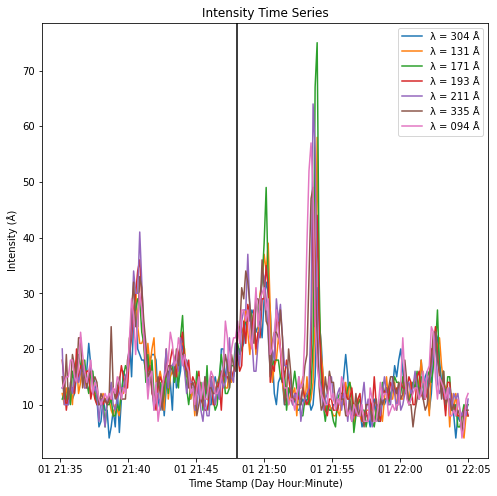

In [81]:
import matplotlib.pyplot as plt

#Creating list for time and wavelength
t = []
i = flarestart
for k in range(0,len(data[:,0,0,0])):
    i = i + duration/len(data[:,0,0,0])
    t.append(i)

wavelengths = ['304 Å', '131 Å', '171 Å', '193 Å', '211 Å', '335 Å', '094 Å']
    
#This plots all 7 graphs at once, without labels to distinguish them yet
for z in range(0,7):
    name = 'λ = ' + wavelengths[z]
    plt.plot(t,data[:,z,0,0], label = name)
    plt.legend()
    plt.title('Intensity Time Series for Flare Event')

#This plots just one wavelength
#plt.plot(t,data[:,0,0,0])

plt.axvline(x = flarepeak, color = 'black')
plt.xlabel('Time Stamp (Day Hour:Minute)')
plt.ylabel('Intensity (Å)')
plt.title('Intensity Time Series')
plt.show()

# Topological Data Analysis

In [82]:
import numpy as np
import plotly.graph_objects as go

#Pick a number 0-6 to correspond to the wavelength you want to look at
w = 6

#Simply graphing the time series data
fig = go.Figure(data=go.Scatter(x=t, y=data[:,0,0,0]))
fig.update_layout(xaxis_title = "Timestamp", 
                  yaxis_title = "Amplitude (Å)", 
                  title = "Time Series of " + wavelengths[w])
fig.show()

# Embedding the Data

In [83]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud

#Define axes as how many dimensions you want the embedded data 
axes = 2

#Embedding the data
embedder_periodic = SingleTakensEmbedding(
    parameters_type = "fixed", n_jobs = 2, time_delay = 8, dimension = axes, stride = 10,)

embedded_data = embedder_periodic.fit_transform(data[:,0,0,0])

#Comparing length of data to embedded data
print('Number of Data Points: ', len(data[:,0,0,0]))
print('Number of Embedded Data Points: ', len(embedded_data))
print("Shape of embedded time series:", embedded_data.shape)

#Plotting embedded data
plot_point_cloud(embedded_data)

Number of Data Points:  200
Number of Embedded Data Points:  20
Shape of embedded time series: (20, 2)


# Persistent Homology

In [84]:
from gtda.homology import VietorisRipsPersistence

#Comverting the embedded data into useful persistence data
persistence_data = embedded_data[None, :, :]

#0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6)

#Grahing a persistence plot
periodic_persistence.fit_transform_plot(persistence_data)
plt.show()